In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.kernel_approximation import RBFSampler
from sklearn.metrics import accuracy_score
from threading import active_count
import time
from sklearn.linear_model import SGDClassifier
from sklearn import  svm, pipeline, datasets
from sklearn.kernel_approximation import RBFSampler, Nystroem
import matplotlib.pyplot as plt

In [ ]:

# reducing the size of the dataset
def channelwise_masking(data):
    masked_data = np.zeros((data.shape[0], 14, 14))
    for i in range(data.shape[0]):
        for j in range(14):
            for k in range(14):
                masked_data[i, j, k] = np.max(data[i, j*2:(j+1)*2, k*2:(k+1)*2])
    return masked_data


# Load MNIST dataset and Fashion-MNIST
mnist = tf.keras.datasets.fashion_mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = channelwise_masking(x_train)
x_test = channelwise_masking(x_test)


d = 14

# Normalize
x_train = (x_train.reshape(-1,d*d))/255
x_test = (x_test.reshape(-1,d*d))/255

x_train -= x_train.mean(axis = 0)
x_test -= x_test.mean(axis = 0)

# reduce datasize
x_train = x_train[:10000]
x_test = x_test[:10000]

y_train = y_train[:10000]
y_test = y_test[:10000]


print(x_train.shape, x_test.shape)



4422102/4422102 [==============================] - 0s 0us/step
(10000, 196) (10000, 196)


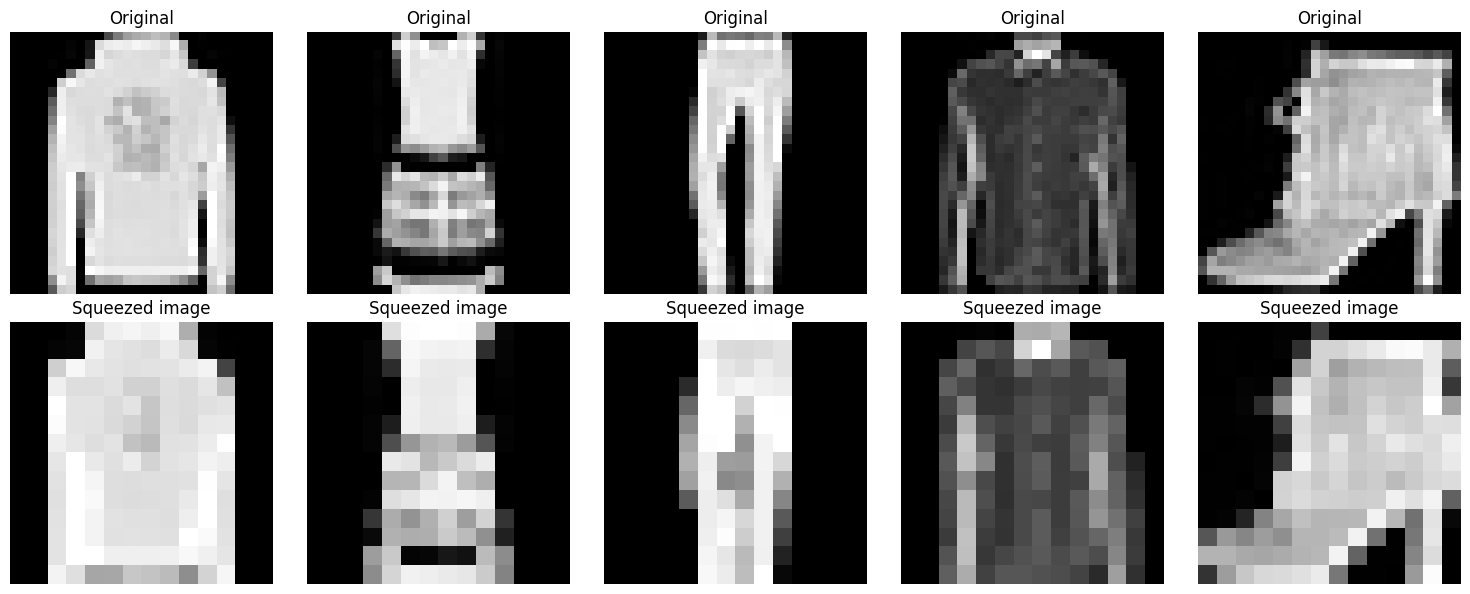

In [ ]:
# visualize images

# load original images
(x_train_org, _), (_, _) = mnist.load_data()

# Select three random samples
sample_indices = np.random.choice(len(x_train), size=5, replace=False)
samples_org = x_train_org[sample_indices]

#apply mask
samples = channelwise_masking(samples_org)

# Plot the original and generated images
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 6))

for i in range(5):
    # Plot original image
    axes[0, i].imshow(samples_org[i], cmap='gray')
    axes[0, i].set_title("Original")
    axes[0, i].axis('off')

    # Plot generated image
    axes[1, i].imshow(samples[i], cmap='gray')
    axes[1, i].set_title("Squeezed image")
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

we now try to seperate the two classes with kernel SMV


In [ ]:

def kernel_svm_separation(X_train, y_train, X_test, y_test):


    # Fit kernel SVM model
    svm_model = SVC(kernel='rbf',gamma = 0.2)
    svm_model.fit(X_train, y_train)

    # Predict on training and test data
    y_train_pred = svm_model.predict(X_train)
    y_test_pred = svm_model.predict(X_test)

    # Calculate training and test accuracy
    train_accuracy = (y_train_pred == y_train).mean()
    test_accuracy = (y_test_pred == y_test).mean()

    return train_accuracy, test_accuracy


def linear_svm_separation(X_train, y_train, X_test, y_test):

    # Fit kernel SVM model
    svm_model = SVC(kernel='linear')
    svm_model.fit(X_train, y_train)

    # Predict on training and test data
    y_train_pred = svm_model.predict(X_train)
    y_test_pred = svm_model.predict(X_test)

    # Calculate training and test accuracy
    train_accuracy = (y_train_pred == y_train).mean()
    test_accuracy = (y_test_pred == y_test).mean()

    return train_accuracy, test_accuracy

In [ ]:


# defining random kernel approximation
def generate_kernel(W,b):

    def ker(x, y):
        z1 = np.cos(x @ W.T + b)
        z2 = np.cos(y @ W.T + b)
        return z1 @ z2.T / np.sqrt(len(b))
    return ker

def approximate_kernel_with_rff(X_train, y_train, X_test, y_test, n_components, gamma):

    # create random features
    feature_map_fourier = RBFSampler(gamma=0.2, random_state=1)

    # transform data
    rff_svm = pipeline.Pipeline(
    [("feature_map", feature_map_fourier), ("svm", svm.LinearSVC())]
    )
    rff_svm.set_params(feature_map__n_components=n_components)

    # fitting SMV
    rff_svm.fit(X_train ,y_train)

    return rff_svm.score(X_test, y_test)


def approximate_kernel_nystroem(X_train, y_train, X_test, y_test, n_components, gamma):

    # create random features
    feature_map_nystroem = Nystroem(gamma=0.2, random_state=1)

    # transform data
    nystroem_svm = pipeline.Pipeline(
    [("feature_map", feature_map_nystroem), ("svm", svm.LinearSVC())]
    )
    nystroem_svm.set_params(feature_map__n_components=n_components)

    # fitting SMV
    nystroem_svm.fit(X_train, y_train)

    return nystroem_svm.score(X_test, y_test)


In [ ]:


def train_randomnized_SVM(rffs, amount, x_train , y_train, x_test, y_test):
  loss = []
  times = []

  for n in rffs:

    # take average over 5 runs
    execution_time = 0
    acc = 0

    for i in  range(amount):
      # Start the timer
      start_time = time.time()

      #train model
      accu = approximate_kernel_with_rff(x_train , y_train, x_test, y_test, n, 1)

      # Stop the timer and calculate the execution time
      execution_time = execution_time + time.time() - start_time

      #calculate loss
      acc = acc + accu

      #print state
      print("I am currently in run with ", n ," RFFs")

    # append on lists
    loss.append(acc/amount)
    times.append(execution_time/amount)
  return loss, times


def train_nystroem_SVM(dimensions, amount, x_train , y_train, x_test, y_test):

  loss = []
  times = []

  for n in dimensions:

    # take average over 5 runs
    execution_time = 0
    acc = 0

    for i in  range(amount):
      # Start the timer
      start_time = time.time()

      #train model
      accu = approximate_kernel_nystroem(x_train , y_train, x_test, y_test, n, 1)

      # Stop the timer and calculate the execution time
      execution_time = execution_time + time.time() - start_time

      #calculate loss
      acc = acc + accu

      #print state
      print("I am currently in run with ", n ," RFFs")

    # append on lists
    loss.append(acc/amount)
    times.append(execution_time/amount)
  return loss, times



In [ ]:


def plot_results(Dataset, RFF_features, acc, computing_times, RBF_kernel_acc, RBF_kernel_time, linear_acc, execution_time_linear):
    # Create figure and axis objects
    fig, (ax1, ax2) = plt.subplots(1,2,figsize = (18,6))

    # Plot the first y-value on the left y-axis
    ax1.plot(RFF_features, acc, color='tab:blue', label='Accuracy', marker = 'x',  linewidth=3.0)
    ax1.set_xlabel('Feature Dimension')
    ax1.set_ylabel('Accuracy')
    ax1.tick_params(axis='y')



    # Plot the second y-value on the right y-axis
    ax2.plot(RFF_features, computing_times, color='darkred', label='Computing time RFFs', marker = 'x', linewidth=3.0)
    ax2.set_ylabel('Computing time in sec')
    ax2.tick_params(axis='y')
    ax2.set_xlabel('Feature Dimension')

    # Plot the dotted horizontal line for the RBF kernel
    ax1.axhline(y=RBF_kernel_acc, color='teal', linestyle='dotted', label='RBF kernel accuracy', linewidth=3.0)
    ax2.axhline(y=RBF_kernel_time, color='red', linestyle='dotted', label='RBF kernel computing time',  linewidth=3.0)

    # Plot the dotted horizontal line for the linear kernel
    ax1.axhline(y=linear_acc, color='purple', linestyle='dotted', label='linear kernel accuracy', linewidth=3.0)
    ax2.axhline(y=execution_time_linear, color='orange', linestyle='dotted', label='Linear kernel computing time', linewidth=3.0)

    # Set plot title and legends
    ax1.set_title('Accuracy on ' + Dataset)
    ax2.set_title('Computing Time on ' + Dataset)
    ax1.legend()
    ax2.legend()

    # Display the plot
    plt.show()

we again test this now with various classes


In [ ]:

rffs = [1,5,10,20,30,50,70,100,150,200,300,500,1000,2000,3000,4000,5000]

loss, times = train_randomnized_SVM(rffs, 5, x_train , y_train, x_test, y_test)

print(loss)
print(times)



In [ ]:
# Start the timer
start_time = time.time()

# compute the rbf kernel SMV
_, kernel_acc = kernel_svm_separation(x_train , y_train, x_test, y_test)

# Stop the timer and calculate the execution time
execution_time_rbf = time.time() - start_time



In [ ]:
# Start the timer
start_time_l = time.time()

# compute the rbf kernel SMV
_, linear_acc = linear_svm_separation(x_train , y_train, x_test, y_test)

# Stop the timer and calculate the execution time
execution_time_linear = time.time() - start_time_l


#comparing with nystrom approx

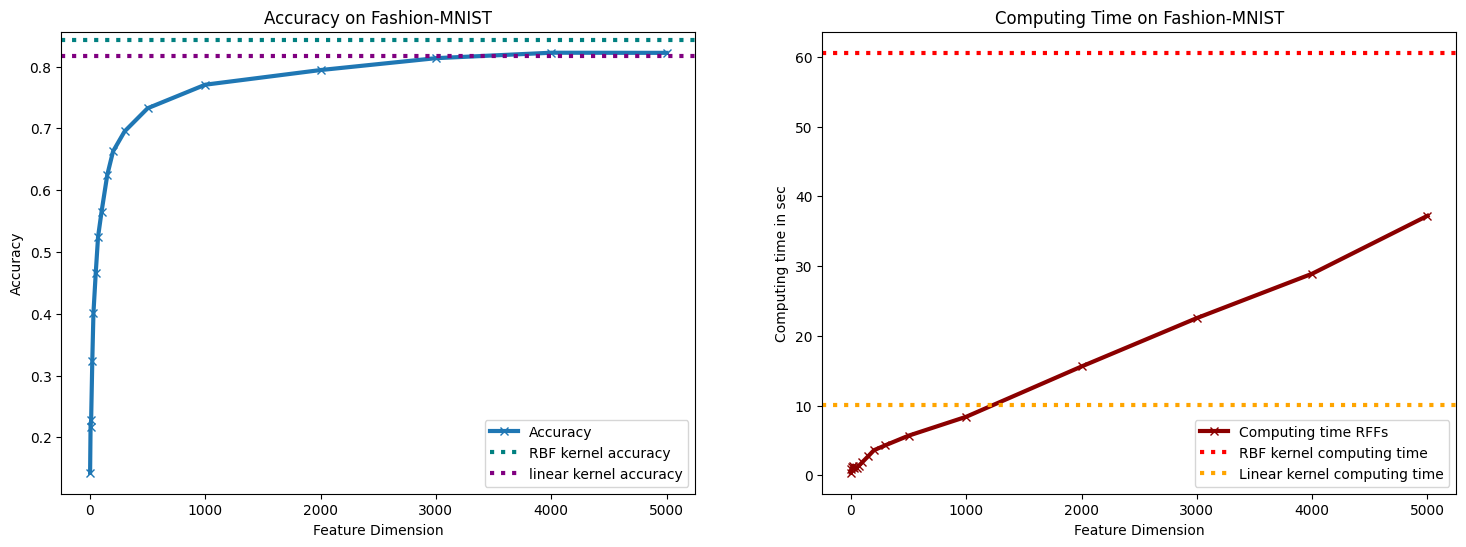

In [ ]:
plot_results("Fashion-MNIST", rffs, loss, times , kernel_acc, execution_time_rbf, linear_acc, execution_time_linear)


# Evaluating with noise

In [ ]:
import copy

# function for adding noise
def make_noise(x_train, noise):

    # define variables
    shape = np.shape(x_train)
    max = np.max(x_train)
    min = np.min(x_train)

    # Add noise
    n = np.random.uniform(min, max, size = shape)
    mask = np.random.choice([0,1], size = shape, p = [noise, 1-noise])
    x_train_noise = np.multiply(x_train,mask) + np.multiply(n, -mask +1)

    return x_train_noise


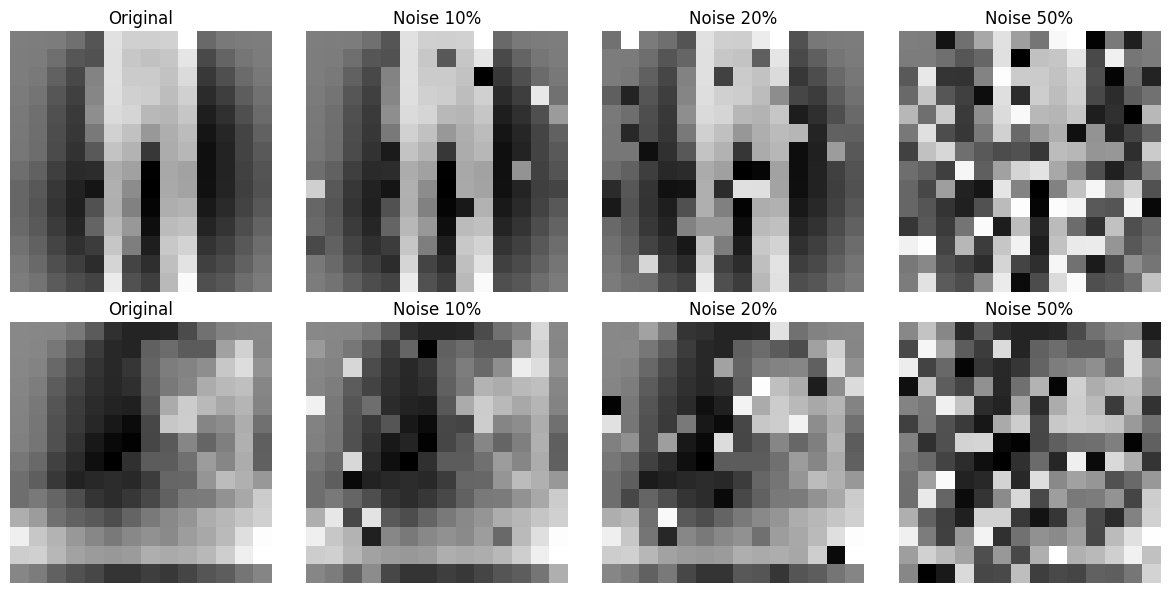

In [ ]:
# visualize noisy data

# Select two random samples
sample_indices = np.random.choice(len(x_train), size=2, replace=False)
samples = (x_train[sample_indices].reshape(2,14,14) + np.min(x_train))*255/np.max(x_train)

# Create a figure with 2 rows and 4 columns
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12, 6))

# Plot original images in the first column
for i, sample in enumerate(samples):
    axes[i, 0].imshow(sample, cmap='gray')
    axes[i, 0].set_title("Original")
    axes[i, 0].axis('off')

# Add noise and plot images in the remaining columns
noise_levels = [0.1, 0.2, 0.5]
for i, sample in enumerate(samples):
    for j, noise_level in enumerate(noise_levels):
        noisy_sample = make_noise(sample, noise_level)
        axes[i, j + 1].imshow(noisy_sample, cmap='gray')
        axes[i, j + 1].set_title(f"Noise {int(noise_level * 100)}%")
        axes[i, j + 1].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
# defining noise level and RFF features
noise_levels = [0,0.05,0.1,0.2,0.3, 0.5]
rffs = [1,5,10,20,30,50,70,100,150,200,300,500,1000,2000,3000,4000,5000]

accuracies = []
times = []

for noise in noise_levels:

  # add noise to data
  x_train_noise = make_noise(x_train, noise)

  # Start the timer
  rff_acc, ex_time_rff = train_randomnized_SVM(rffs, 3, x_train_noise, y_train, x_test, y_test)

  # append results
  accuracies.append(rff_acc)
  times.append(ex_time_rff)



I am currently in run with  1  RFFs
I am currently in run with  1  RFFs
I am currently in run with  1  RFFs
I am currently in run with  5  RFFs
I am currently in run with  5  RFFs
I am currently in run with  5  RFFs
I am currently in run with  10  RFFs
I am currently in run with  10  RFFs
I am currently in run with  10  RFFs
I am currently in run with  20  RFFs
I am currently in run with  20  RFFs
I am currently in run with  20  RFFs
I am currently in run with  30  RFFs
I am currently in run with  30  RFFs
I am currently in run with  30  RFFs
I am currently in run with  50  RFFs
I am currently in run with  50  RFFs
I am currently in run with  50  RFFs
I am currently in run with  70  RFFs
I am currently in run with  70  RFFs
I am currently in run with  70  RFFs
I am currently in run with  100  RFFs
I am currently in run with  100  RFFs
I am currently in run with  100  RFFs
I am currently in run with  150  RFFs
I am currently in run with  150  RFFs
I am currently in run with  150  RFFs
I

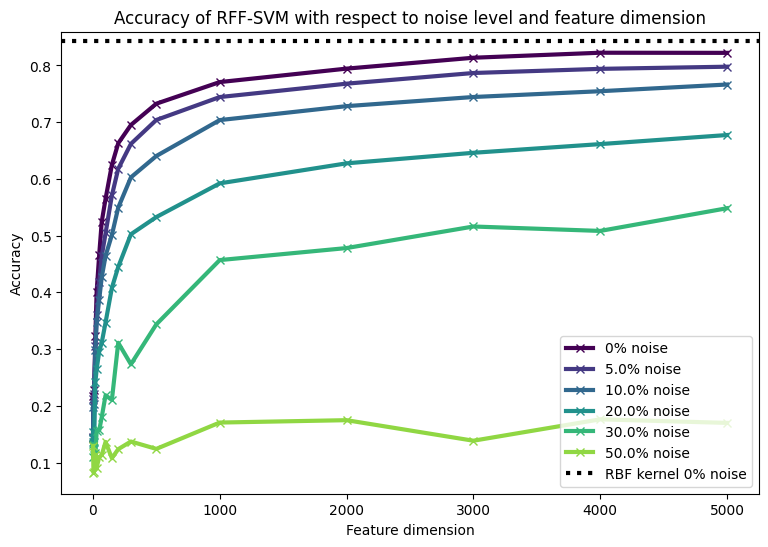

In [ ]:


def plot_list_of_lists(rffs,accuracies,noise_level):

    data_array = np.array(accuracies)

    # Generate a color map using the 'viridis' colormap
    cmap = plt.get_cmap('viridis')

    # Determine the number of sublists (rows) and the maximum length of the sublists (columns)
    num_rows = len(accuracies)
    max_length = len(rffs)

    # Create a figure and axis object
    fig, ax = plt.subplots(figsize = (9,6))

    # Iterate over each sublist and plot it using a line plot
    for i, sublist in enumerate(accuracies):
        # Normalize the sublist length to match the longest sublist
        normalized_length = i / len(accuracies)

        # Generate a color based on the normalized length using the color map
        color = cmap(normalized_length)

        # Plot the sublist as a line with the determined color
        ax.plot(rffs, sublist, color=color, label = str(noise_level[i]*100) + '% noise', marker = 'x', linewidth=3.0)

    # Set the title and labels for the plot
    ax.set_title('Accuracy of RFF-SVM with respect to noise level and feature dimension')
    ax.set_xlabel('Feature dimension')
    ax.set_ylabel('Accuracy')


    # Plot the dotted horizontal line for the linear kernel0)
    ax.axhline(y=kernel_acc, color='black', linestyle='dotted', label='RBF kernel 0% noise', linewidth=3.0)



    ax.legend()
    # Show the plot
    plt.show()

plot_list_of_lists(rffs,accuracies, noise_levels)

#Comparing to Nystroem


In [ ]:
dimensions = [1,5,10,20,30,40, 50,100 ,150, 200, 250, 300, 400, 500, 1000, 2000, 3000, 5000]


loss_rff, times_rff = train_randomnized_SVM(dimensions, 5, x_train , y_train, x_test, y_test)
loss_nystr, times_nystr = train_nystroem_SVM(dimensions, 2, x_train , y_train, x_test, y_test)




I am currently in run with  1  RFFs
I am currently in run with  1  RFFs
I am currently in run with  1  RFFs
I am currently in run with  1  RFFs
I am currently in run with  1  RFFs
I am currently in run with  5  RFFs
I am currently in run with  5  RFFs
I am currently in run with  5  RFFs
I am currently in run with  5  RFFs
I am currently in run with  5  RFFs
I am currently in run with  10  RFFs
I am currently in run with  10  RFFs
I am currently in run with  10  RFFs
I am currently in run with  10  RFFs
I am currently in run with  10  RFFs
I am currently in run with  20  RFFs
I am currently in run with  20  RFFs
I am currently in run with  20  RFFs
I am currently in run with  20  RFFs
I am currently in run with  20  RFFs
I am currently in run with  30  RFFs
I am currently in run with  30  RFFs
I am currently in run with  30  RFFs
I am currently in run with  30  RFFs
I am currently in run with  30  RFFs
I am currently in run with  40  RFFs
I am currently in run with  40  RFFs
I am curren

In [ ]:
def plot_results_compare(Dataset, RFF_features, acc, computing_times, acc_nystroem, computing_times_nystroem ,RBF_kernel_acc, RBF_kernel_time, linear_acc, execution_time_linear):
    # Create figure and axis objects
    fig, (ax1, ax2) = plt.subplots(1,2,figsize = (18,6))

    # Plot the first y-value on the left y-axis
    ax1.plot(RFF_features, acc, color='darkred', label='Accuracy RFF', marker = 'x',  linewidth=3.0)
    ax1.plot(RFF_features, acc_nystroem, color='tab:blue', label='Accuracy Nystroem', marker = 'x',  linewidth=3.0)
    ax1.set_xlabel('Feature dimension')
    ax1.set_ylabel('Accuracy')
    ax1.tick_params(axis='y')



    # Plot the second y-value on the right y-axis
    ax2.plot(RFF_features, computing_times, color='darkred', label='Computing times RFFs', marker = 'x', linewidth=3.0)
    ax2.plot(RFF_features, computing_times_nystroem, color='tab:blue', label='Computing times Nystroem', marker = 'x', linewidth=3.0)
    ax2.set_ylabel('Computing time in sec.')
    ax2.tick_params(axis='y')
    ax2.set_xlabel('Feature dimension')

    # Plot the dotted horizontal line for the RBF kernel
    ax1.axhline(y=RBF_kernel_acc, color='teal', linestyle='dotted', label='RBF kernel accuracy', linewidth=3.0)
    ax2.axhline(y=RBF_kernel_time, color='teal', linestyle='dotted', label='RBF kernel computing time',  linewidth=3.0)

    # Plot the dotted horizontal line for the linear kernel
    ax1.axhline(y=linear_acc, color='purple', linestyle='dotted', label='Linear kernel accuracy', linewidth=3.0)
    ax2.axhline(y=execution_time_linear, color='purple', linestyle='dotted', label='Linear kernel computing time', linewidth=3.0)

    # Set plot title and legends
    ax1.set_title('Accuracy on ' + Dataset)
    ax2.set_title('Computing time on ' + Dataset)
    ax1.legend()
    ax2.legend()

    # Display the plot
    plt.show()

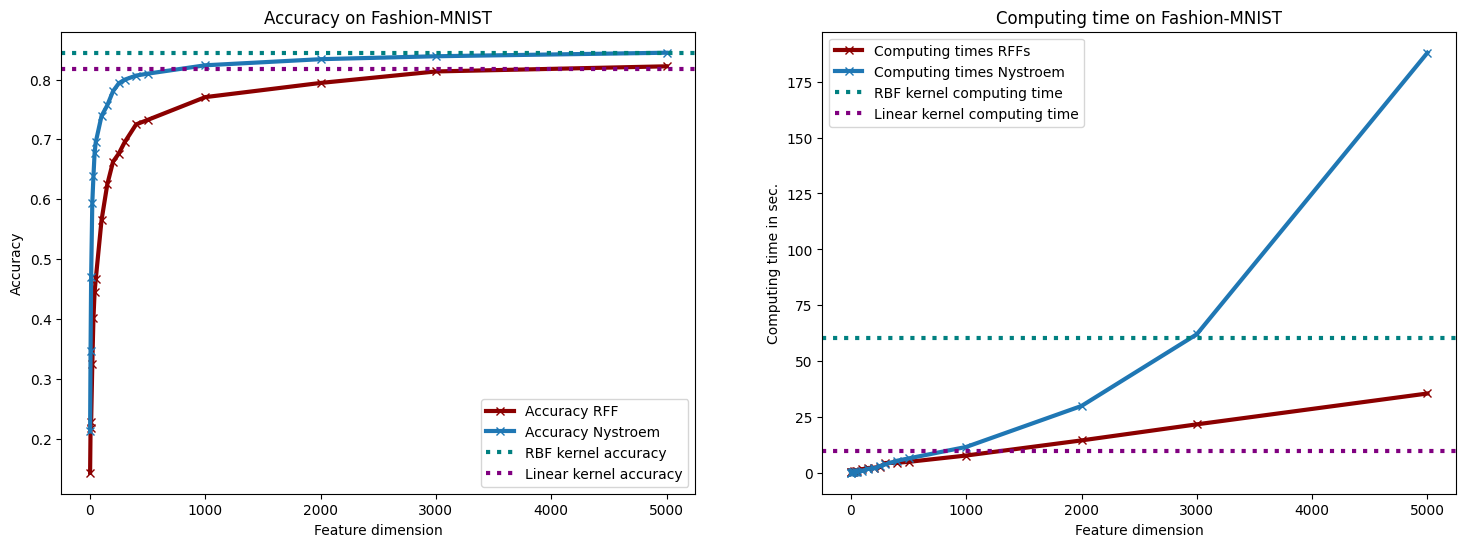

In [ ]:
plot_results_compare('Fashion-MNIST', dimensions, loss_rff, times_rff, loss_nystr, times_nystr ,kernel_acc, execution_time_rbf, linear_acc, execution_time_linear)

In [ ]:
from sklearn.decomposition import PCA
import time

def classify_svm(dimension, X_train, y_train, X_test, y_test, kernel):

    # Start time
    start_time = time.time()

    # Dimensionality reduction using PCA
    pca = PCA(n_components=dimension)
    X_train_reduced = pca.fit_transform(X_train)
    X_test_reduced = pca.transform(X_test)


    # Calculating accuracy
    accuracy = 0
    if kernel == 'linear':
      _, accuracy = linear_svm_separation(X_train_reduced, y_train, X_test_reduced, y_test)
    else:
      _, accuracy = kernel_svm_separation(X_train_reduced, y_train, X_test_reduced, y_test)

    training_time =  time.time() - start_time

    # print status
    print("current run: ", dimension)

    return accuracy, training_time

In [ ]:
dimensions = [1,2,3,5,7,10,15,20,30,40, 50,60,70, 80,100, 120 ,150,170, 195]



accuracy_pca = []
times_pca = []

for d in dimensions:
  acc, comp_time = classify_svm(d, x_train, y_train, x_test, y_test, 'linear')
  accuracy_pca.append(acc)
  times_pca.append(comp_time)


accuracy_pca_rbf = []
times_pca_rbf = []

for d in dimensions:
  acc, comp_time = classify_svm(d, x_train, y_train, x_test, y_test, 'rbf')
  accuracy_pca_rbf.append(acc)
  times_pca_rbf.append(comp_time)





current run:  1
current run:  2
current run:  3
current run:  5
current run:  7
current run:  10
current run:  15
current run:  20
current run:  30
current run:  40
current run:  50
current run:  60
current run:  70
current run:  80
current run:  100
current run:  120
current run:  150
current run:  170
current run:  195
current run:  1
current run:  2
current run:  3
current run:  5
current run:  7
current run:  10
current run:  15
current run:  20
current run:  30
current run:  40
current run:  50
current run:  60
current run:  70
current run:  80
current run:  100
current run:  120
current run:  150
current run:  170
current run:  195


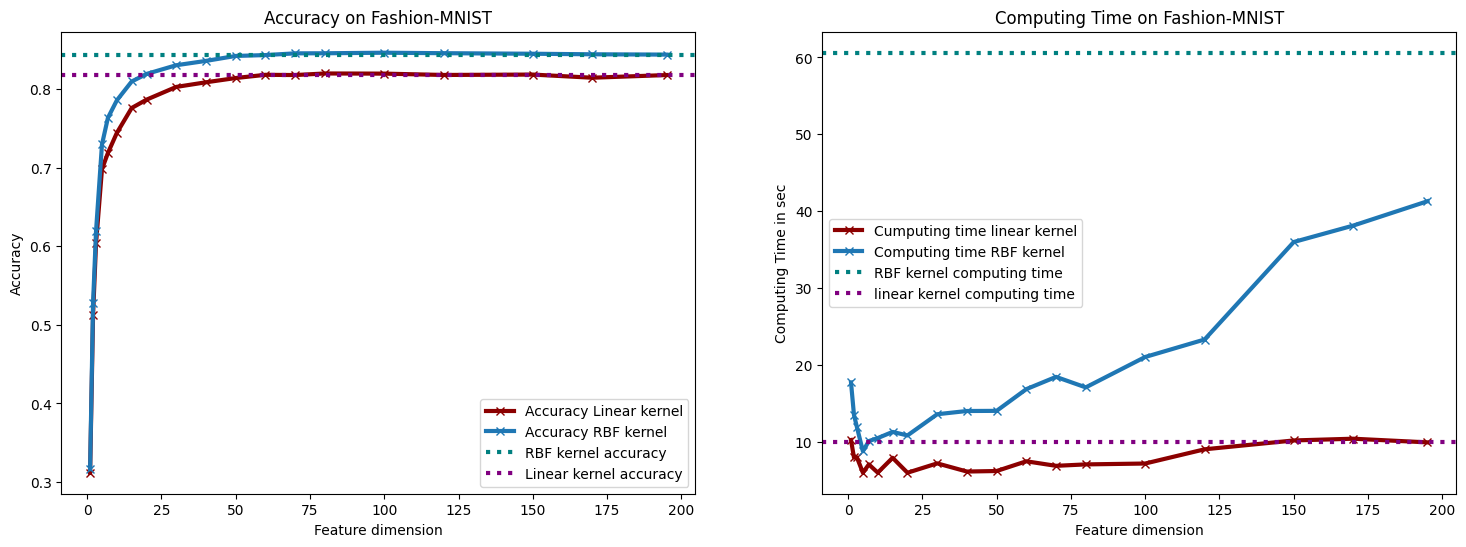

In [ ]:
Dataset = 'Fashion-MNIST'

# Create figure and axis objects
fig, (ax1, ax2) = plt.subplots(1,2,figsize = (18,6))

# Plot the first y-value on the left y-axis
ax1.plot(dimensions, accuracy_pca, color='darkred', label='Accuracy Linear kernel', marker = 'x',  linewidth=3.0)
ax1.plot(dimensions, accuracy_pca_rbf, color='tab:blue', label='Accuracy RBF kernel', marker = 'x',  linewidth=3.0)
ax1.set_xlabel('Feature dimension')
ax1.set_ylabel('Accuracy')
ax1.tick_params(axis='y')



# Plot the second y-value on the right y-axis
ax2.plot(dimensions, times_pca, color='darkred', label='Cumputing time linear kernel', marker = 'x', linewidth=3.0)
ax2.plot(dimensions, times_pca_rbf, color='tab:blue', label='Computing time RBF kernel', marker = 'x', linewidth=3.0)
ax2.set_ylabel('Computing Time in sec')
ax2.tick_params(axis='y')
ax2.set_xlabel('Feature dimension')

# Plot the dotted horizontal line for the RBF kernel
ax1.axhline(y=kernel_acc, color='teal', linestyle='dotted', label='RBF kernel accuracy', linewidth=3.0)
ax2.axhline(y=execution_time_rbf, color='teal', linestyle='dotted', label='RBF kernel computing time',  linewidth=3.0)

# Plot the dotted horizontal line for the linear kernel
ax1.axhline(y=linear_acc, color='purple', linestyle='dotted', label='Linear kernel accuracy', linewidth=3.0)
ax2.axhline(y=execution_time_linear, color= 'purple', linestyle='dotted', label='linear kernel computing time', linewidth=3.0)

# Set plot title and legends
ax1.set_title('Accuracy on ' + Dataset)
ax2.set_title('Computing Time on ' + Dataset)
ax1.legend()
ax2.legend()

# Display the plot
plt.show()

# Doing the same with noisy data


In [ ]:
dimensions = [1,2,3,5,7,10,15,20,30,40, 50,60,70, 80,100, 120 ,150,170, 195]
noise_levels = [0,0.05,0.1,0.2,0.3, 0.5]



accuracies = []
times = []

for noise in noise_levels:

  # add noise to data
  x_train_noise = make_noise(x_train, noise)

  acc = []
  tim = []
  for d in dimensions:
    # Start the timer
    rff_acc, ex_time_rff = classify_svm(d, x_train_noise, y_train, x_test, y_test, 'rbf')
    acc.append(rff_acc)
    tim.append(ex_time_rff)
    print("run with ", d ," dimensions")

  # append results
  print("run with ", noise ," noise")
  accuracies.append(acc)
  times.append(tim)




current run:  1
run with  1  dimensions
current run:  2
run with  2  dimensions
current run:  3
run with  3  dimensions
current run:  5
run with  5  dimensions
current run:  7
run with  7  dimensions
current run:  10
run with  10  dimensions
current run:  15
run with  15  dimensions
current run:  20
run with  20  dimensions
current run:  30
run with  30  dimensions
current run:  40
run with  40  dimensions
current run:  50
run with  50  dimensions
current run:  60
run with  60  dimensions
current run:  70
run with  70  dimensions
current run:  80
run with  80  dimensions
current run:  100
run with  100  dimensions
current run:  120
run with  120  dimensions
current run:  150
run with  150  dimensions
current run:  170
run with  170  dimensions
current run:  195
run with  195  dimensions
run with  0  noise
current run:  1
run with  1  dimensions
current run:  2
run with  2  dimensions
current run:  3
run with  3  dimensions
current run:  5
run with  5  dimensions
current run:  7
run wit

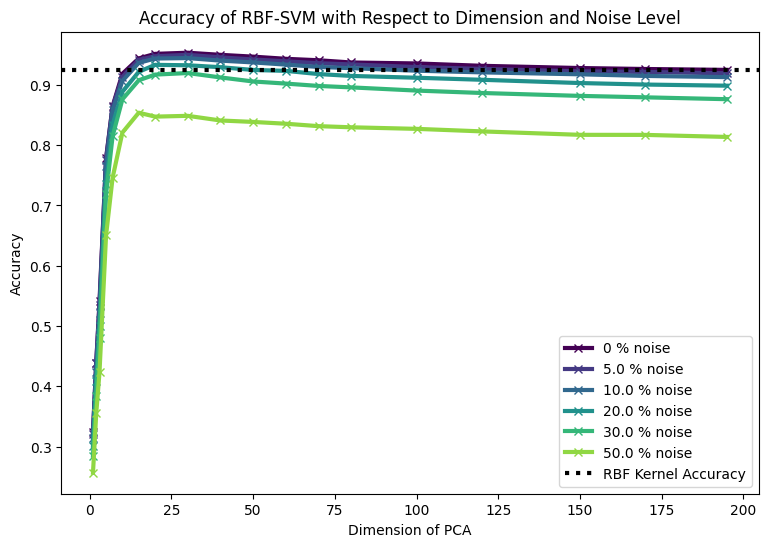

In [ ]:
plot_list_of_lists(dimensions,accuracies, noise_levels)

# Ensemble Learning

We need over 50% accuracy. taking 300 RFF, 500RFF and 1000RRF
we construct 11 classifier and take the argmax of the votes

In [ ]:
# defining some parameters
amount_of_classifier = 15
rffs = [3,50,100,150,300,500,1000,2000,3000]

In [ ]:
# creating classifier class. Together we strong!
class weak_classifier:

  def __init__(self, rffs):
    self.rffs = rffs

    # create random features
    self.feature_map_fourier = RBFSampler(gamma=0.2)

    # transform data
    self.rff_svm = pipeline.Pipeline(
    [("feature_map", self.feature_map_fourier), ("svm", svm.LinearSVC())]
    )
    self.rff_svm.set_params(feature_map__n_components= self.rffs)


  def fit(self, x_train, y_train):
    # fitting SMV
    self.rff_svm.fit(x_train ,y_train)

  def evaluate(self, x_test, y_test):
    # evaluate
    return self.rff_svm.score(x_test, y_test)

  def vote(self, x_test):
    return self.rff_svm.predict(x_test)



In [ ]:
accuracies = []
combined_acc = []
total_time = []
avg_acc = []

for rff in rffs:
  # generating classifier
  classifier = [weak_classifier(rff) for i in range(amount_of_classifier)]

  # starting the time
  start_time = time.time()

  # fit classifier
  for c in classifier:
    c.fit(x_train,y_train)

  # stop timer
  training_time =  time.time() - start_time

  # collecting votes
  votes = [np.argmax(np.bincount(vote)) for vote in np.transpose(np.array([c.vote(x_test) for c in classifier]))]

  # calculating score
  accuracy = (votes == y_test).mean()

  # get avg accuracy
  avg_accuracy = np.array([c.evaluate(x_test,y_test) for c in classifier]).mean()

  # appending results
  combined_acc.append(accuracy)
  total_time.append(training_time)
  avg_acc.append(avg_accuracy)

  # print status
  print("finished run with ", rff , " RFFs!")


finished run with  3  RFFs!
finished run with  50  RFFs!
finished run with  100  RFFs!
finished run with  150  RFFs!
finished run with  300  RFFs!
finished run with  500  RFFs!
finished run with  1000  RFFs!
finished run with  2000  RFFs!
finished run with  3000  RFFs!


In [ ]:
print(combined_acc)
print(avg_acc)
_, times_rff = train_randomnized_SVM(rffs, 1, x_train , y_train, x_test, y_test)

[0.1735, 0.5591, 0.7098, 0.7696, 0.8523, 0.889, 0.9199]
[0.1578, 0.3731818181818181, 0.48927272727272725, 0.5511545454545455, 0.6652454545454547, 0.7345636363636363, 0.8095545454545454]
I am currently in run with  3  RFFs
I am currently in run with  50  RFFs
I am currently in run with  100  RFFs
I am currently in run with  150  RFFs
I am currently in run with  300  RFFs
I am currently in run with  500  RFFs
I am currently in run with  1000  RFFs


# Generating first plot

In [ ]:
def plot_ensemble_results(dimensions,ensemble_acc, avg_acc, ensemble_time , rbf_kernel_acc, rbf_kernel_time):

  Dataset = 'MNIST'

  # Create figure and axis objects
  fig, (ax1, ax2) = plt.subplots(1,2,figsize = (18,6))

  # Plot the first y-value on the left y-axis
  ax1.plot(dimensions, ensemble_acc, color='darkred', label='Accuracy of combined-classifier', marker = 'x',  linewidth=3.0)
  ax1.plot(dimensions, avg_acc, color='tab:blue', label='Average accuracy', marker = 'x',  linewidth=3.0)
  ax1.set_xlabel('Feature dimension')
  ax1.set_ylabel('Accuracy')
  ax1.tick_params(axis='y')



  # Plot the second y-value on the right y-axis
  ax2.plot(dimensions, ensemble_time, color='darkred', label='Cumputing time of combined-classifier', marker = 'x', linewidth=3.0)
  ax2.plot(dimensions, np.array(ensemble_time)/11, color='tab:blue', label='Average computing time', marker = 'x',  linewidth=3.0)
  ax2.set_ylabel('Computing time in sec')
  ax2.set_xlabel('Feature dimension')
  ax2.tick_params(axis='y')

  # Plot the dotted horizontal line for the RBF kernel
  ax1.axhline(y=rbf_kernel_acc, color='teal', linestyle='dotted', label='RBF kernel accuracy', linewidth=3.0)
  ax2.axhline(y=rbf_kernel_time, color='teal', linestyle='dotted', label='RBF kernel computing time',  linewidth=3.0)


  # Set plot title and legends
  ax1.set_title('Accuracy on ' + Dataset)
  ax2.set_title('Computing time on ' + Dataset)
  ax1.legend()
  ax2.legend()

  # Display the plot
  plt.show()



plot_ensemble_results(rffs,combined_acc, avg_acc, total_time , kernel_acc, kernel_comp)

In [ ]:
rffs = [50,100,150]
amount_of_classifiers = [1,3,5,11,25,50,75,100]


accuracies = []

for rff in rffs:

  combined_acc = []

  for a in amount_of_classifiers:
    # generating classifier
    classifier = [weak_classifier(rff) for i in range(a)]

    # fit classifier
    for c in classifier:
      c.fit(x_train,y_train)

    # collecting votes
    votes = [np.argmax(np.bincount(vote)) for vote in np.transpose(np.array([c.vote(x_test) for c in classifier]))]

    # calculating score
    accuracy = (votes == y_test).mean()

    # get avg accuracy
    avg_accuracy = np.array([c.evaluate(x_test,y_test) for c in classifier]).mean()

    # appending results
    combined_acc.append(accuracy)

  # append results
  accuracies.append(combined_acc)

  # print status
  print("finished run with ", rff , " RFFs!")



finished run with  50  RFFs!
finished run with  100  RFFs!
finished run with  150  RFFs!


In [ ]:
print(accuracies)

[[0.3539, 0.4328, 0.4908, 0.5691, 0.6487, 0.685, 0.7015, 0.714], [0.47, 0.5438, 0.609, 0.6924, 0.7769, 0.814, 0.8301, 0.8412], [0.5471, 0.6226, 0.7021, 0.7734, 0.8249, 0.8603, 0.876, 0.8807]]


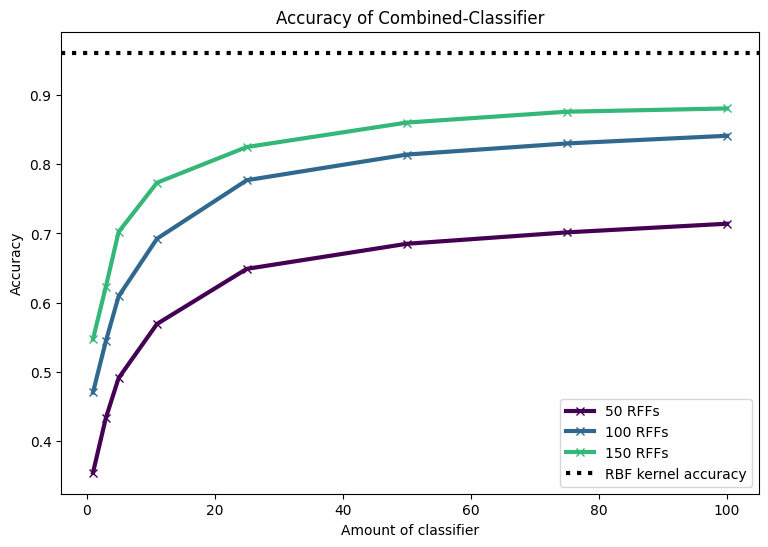

In [ ]:
def plot_list_of_lists(rffs,accuracies,noise_level):

    data_array = np.array(accuracies)

    # Generate a color map using the 'viridis' colormap
    cmap = plt.get_cmap('viridis')

    # Determine the number of sublists (rows) and the maximum length of the sublists (columns)
    num_rows = len(accuracies)
    max_length = len(rffs)

    # Create a figure and axis object
    fig, ax = plt.subplots(figsize = (9,6))

    # Iterate over each sublist and plot it using a line plot
    for i, sublist in enumerate(accuracies):
        # Normalize the sublist length to match the longest sublist
        normalized_length = i / len(accuracies)

        # Generate a color based on the normalized length using the color map
        color = cmap(normalized_length)

        # Plot the sublist as a line with the determined color
        ax.plot(rffs, sublist, color=color, label = str(noise_level[i]) + ' RFFs', marker = 'x', linewidth=3.0)

    # Set the title and labels for the plot
    ax.set_title('Accuracy of Combined-Classifier')
    ax.set_xlabel('Amount of classifier')
    ax.set_ylabel('Accuracy')


    # Plot the dotted horizontal line for the linear kernel0)
    ax.axhline(y=kernel_acc, color='black', linestyle='dotted', label='RBF kernel accuracy', linewidth=3.0)



    ax.legend()
    # Show the plot
    plt.show()

plot_list_of_lists(amount_of_classifiers,accuracies,rffs)